### 1. Importing Necessary Libraries


In [88]:
# Import required libraries for data processing, visualization, and model building
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout
import yfinance as yf

### 2. Fetching Gold Price Data

In [89]:
# Define the time period for data extraction
start_date = "2000-01-01"
end_date = "2024-12-31"

# Download gold price data using Yahoo Finance
data = yf.download("GC=F", start=start_date, end=end_date)

# Select and preprocess the 'Close' column
data = data[['Close']].dropna()
data.rename(columns={'Close': 'Gold Price'}, inplace=True)

# Add additional features such as moving averages and volatility
data['Moving Average 5'] = data['Gold Price'].rolling(window=5).mean()
data['Moving Average 10'] = data['Gold Price'].rolling(window=10).mean()
data['Moving Average 50'] = data['Gold Price'].rolling(window=50).mean()
data['Moving Average 200'] = data['Gold Price'].rolling(window=200).mean()
data['Volatility'] = data['Gold Price'].pct_change().rolling(window=5).std()

# Drop rows with NaN values caused by rolling calculations
data = data.dropna()

[*********************100%***********************]  1 of 1 completed


In [90]:
data

Price,Gold Price,Moving Average 5,Moving Average 10,Moving Average 50,Moving Average 200,Volatility
Ticker,GC=F,,,,,
Date,,,,,,
2001-06-18,272.399994,272.479999,270.110001,268.215999,267.303999,0.011348
2001-06-19,273.399994,272.859998,270.879999,268.483998,267.301499,0.009939
2001-06-20,272.399994,272.939996,271.549997,268.765999,267.271999,0.010184
2001-06-21,272.600006,272.400000,272.209998,269.071999,267.249999,0.007904
2001-06-22,272.299988,272.619995,272.099997,269.343998,267.232499,0.003349
...,...,...,...,...,...,...
2024-12-02,2634.899902,2638.359961,2646.589990,2667.528003,2425.985494,0.006327
2024-12-03,2644.699951,2643.239941,2648.349976,2667.398003,2429.071494,0.006411


### 3. Visualizing the Gold Price Trend

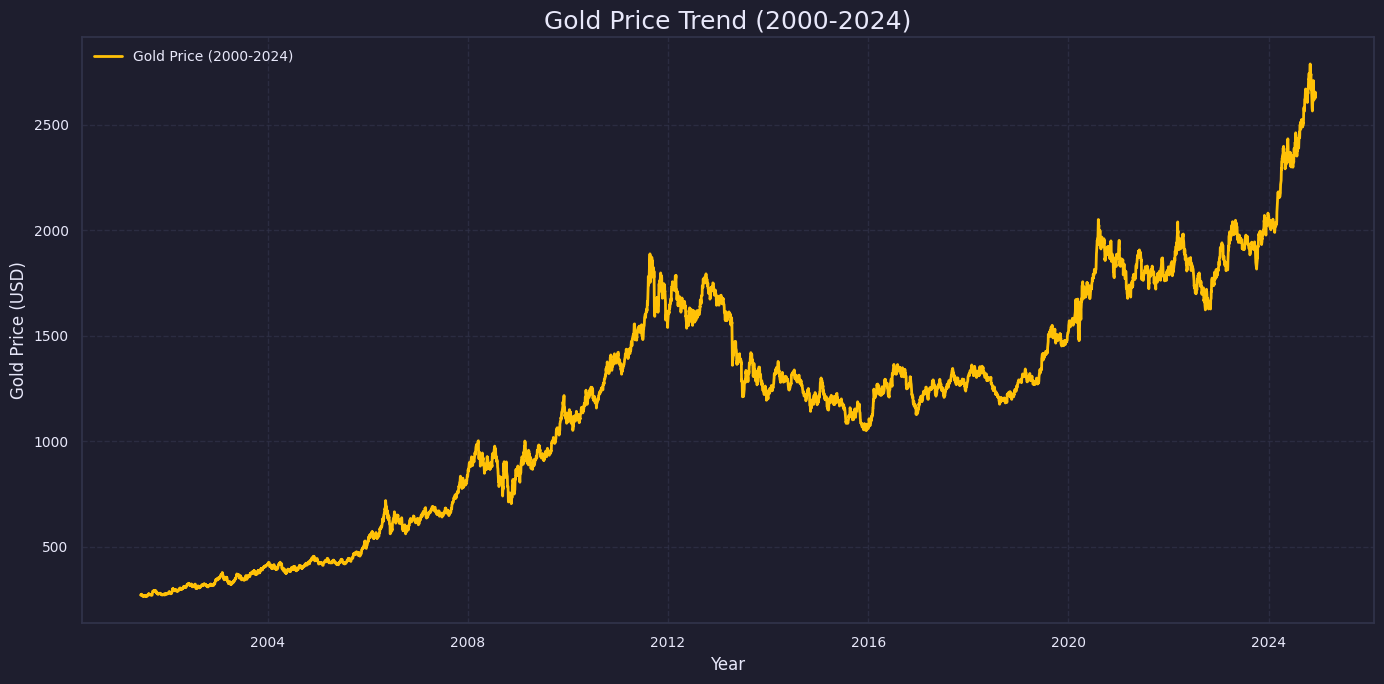

In [91]:
# Custom dark background color
background_color = '#1e1e2e'
grid_color = '#31334a'
text_color = '#e8e8fa'

# Set seaborn theme with manual adjustments
sns.set_theme(style="darkgrid")
plt.rcParams.update({
    'axes.facecolor': background_color,  # Dark background for the plot
    'axes.edgecolor': grid_color,
    'grid.color': grid_color,  # Subtle grid color
    'text.color': text_color,  # Light text for readability
    'xtick.color': text_color,
    'ytick.color': text_color,
    'legend.facecolor': background_color,  # Legend with matching background
    'legend.edgecolor': grid_color,
    'axes.labelcolor': text_color,
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 100
})

# Plot the historical gold price data
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Gold Price'], label="Gold Price (2000-2024)", color='#FFC107', linewidth=2)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Gold Price (USD)", fontsize=12)
plt.title("Gold Price Trend (2000-2024)", fontsize=18, color=text_color)
plt.legend(loc="upper left", fontsize=10, frameon=False)
plt.grid(color=grid_color, linestyle='--', alpha=0.7)

# Adjust layout and overall figure background
plt.gcf().patch.set_facecolor(background_color)
plt.tight_layout()
plt.show()


### 4. Preprocessing the Data

In [92]:
# Select features for modeling
features = ['Gold Price', 'Moving Average 5', 'Moving Average 10', 'Moving Average 50', 'Moving Average 200', 'Volatility']

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features])

# Function to create sequences for time series forecasting
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Predict 'Gold Price'
    return np.array(x), np.array(y)

# Define sequence length and create sequences
seq_length = 60
x, y = create_sequences(data_scaled, seq_length)

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(x) * 0.8)
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

# Reshape data for LSTM, GRU, and RNN models
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2]))

In [93]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(4665, 60, 6) (4665,)
(1167, 60, 6) (1167,)


### 5. Building and Training LSTM Model

In [94]:
# Define LSTM model architecture
lstm_model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile and train the LSTM model
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 60, 128)             │          69,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,593 (463.25 KB)

 Trainable params: 118,593 (463.25 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
lstm_history = lstm_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - loss: 0.0179 - val_loss: 5.4825e-04
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - loss: 0.0013 - val_loss: 5.4096e-04
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - loss: 0.0012 - val_loss: 3.9919e-04
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - loss: 0.0010 - val_loss: 3.8917e-04
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.0010 - val_loss: 4.4478e-04
Epoch 9/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 8.6007e-04 - val_loss: 3.7235e-04
Epoch 10/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - loss: 8.6067e-04 - val_loss: 4.7009e-04


### 6. Building and Training GRU Model

In [96]:
# Define GRU model architecture
gru_model = Sequential([
    GRU(128, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    GRU(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile and train the GRU model
gru_model.compile(optimizer='adam', loss='mse')

gru_model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                         │ (None, 60, 128)             │          52,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_13 (GRU)                         │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,537 (349.75 KB)

 Trainable params: 89,537 (349.75 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
gru_history = gru_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - loss: 0.0176 - val_loss: 0.0020
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - loss: 0.0018 - val_loss: 7.9562e-04
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - loss: 0.0013 - val_loss: 7.1692e-04
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - loss: 0.0012 - val_loss: 5.8262e-04
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - loss: 0.0011 - val_loss: 5.2379e-04
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - loss: 9.6112e-04 - val_loss: 0.0011
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - loss: 8.9180e-04 - val_loss: 5.3646e-04
Epoch 9/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - loss: 8.5832e-04 - val_loss: 5.1229e-04
Epoch 10/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - loss: 7.7964e-04 - val_loss: 6.6925e-04


### 7. Building and Training RNN Model

In [98]:
# Define RNN model architecture
rnn_model = Sequential([
    SimpleRNN(128, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    SimpleRNN(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile and train the RNN model
rnn_model.compile(optimizer='adam', loss='mse')

rnn_model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)            │ (None, 60, 128)             │          17,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_11 (SimpleRNN)            │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,697 (116.00 KB)

 Trainable params: 29,697 (116.00 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
rnn_history = rnn_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0264 - val_loss: 0.0049
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0023 - val_loss: 0.0051
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0020 - val_loss: 2.1779e-04
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0017 - val_loss: 7.5138e-04
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0014 - val_loss: 7.3737e-04
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0013 - val_loss: 2.5718e-04
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0011 - val_loss: 2.4099e-04
Epoch 9/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0010 - val_loss: 2.2975e-04
Epoch 10/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 9.4551e-04 - val_loss: 8.8780e-04


### 8. Evaluating Models and Visualizing Predictions

In [100]:
# Evaluate and Predict with LSTM
y_train_pred_lstm = lstm_model.predict(x_train)
y_test_pred_lstm = lstm_model.predict(x_test)

# Inverse transform predictions and true values for LSTM
y_train_pred_inv_lstm = scaler.inverse_transform(np.concatenate((y_train_pred_lstm, np.zeros((y_train_pred_lstm.shape[0], len(features)-1))), axis=1))[:, 0]
y_test_pred_inv_lstm = scaler.inverse_transform(np.concatenate((y_test_pred_lstm, np.zeros((y_test_pred_lstm.shape[0], len(features)-1))), axis=1))[:, 0]
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], len(features)-1))), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features)-1))), axis=1))[:, 0]

146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [101]:
# Evaluate and Predict with GRU
y_train_pred_gru = gru_model.predict(x_train)
y_test_pred_gru = gru_model.predict(x_test)

# Inverse transform predictions and true values for GRU
y_train_pred_inv_gru = scaler.inverse_transform(np.concatenate((y_train_pred_gru, np.zeros((y_train_pred_gru.shape[0], len(features)-1))), axis=1))[:, 0]
y_test_pred_inv_gru = scaler.inverse_transform(np.concatenate((y_test_pred_gru, np.zeros((y_test_pred_gru.shape[0], len(features)-1))), axis=1))[:, 0]

146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [102]:
# Evaluate and Predict with RNN
y_train_pred_rnn = rnn_model.predict(x_train)
y_test_pred_rnn = rnn_model.predict(x_test)

# Inverse transform predictions and true values for RNN
y_train_pred_inv_rnn = scaler.inverse_transform(np.concatenate((y_train_pred_rnn, np.zeros((y_train_pred_rnn.shape[0], len(features)-1))), axis=1))[:, 0]
y_test_pred_inv_rnn = scaler.inverse_transform(np.concatenate((y_test_pred_rnn, np.zeros((y_test_pred_rnn.shape[0], len(features)-1))), axis=1))[:, 0]

146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [103]:
# Calculate R² Scores for LSTM, GRU, and RNN
train_r2_lstm = r2_score(y_train_inv, y_train_pred_inv_lstm)
test_r2_lstm = r2_score(y_test_inv, y_test_pred_inv_lstm)

train_r2_gru = r2_score(y_train_inv, y_train_pred_inv_gru)
test_r2_gru = r2_score(y_test_inv, y_test_pred_inv_gru)

train_r2_rnn = r2_score(y_train_inv, y_train_pred_inv_rnn)
test_r2_rnn = r2_score(y_test_inv, y_test_pred_inv_rnn)

print(f"LSTM R² Score on Training Data: {train_r2_lstm:.4f}")
print(f"LSTM R² Score on Testing Data: {test_r2_lstm:.4f}")
print(f"GRU R² Score on Training Data: {train_r2_gru:.4f}")
print(f"GRU R² Score on Testing Data: {test_r2_gru:.4f}")
print(f"RNN R² Score on Training Data: {train_r2_rnn:.4f}")
print(f"RNN R² Score on Testing Data: {test_r2_rnn:.4f}")

LSTM R² Score on Training Data: 0.9949
LSTM R² Score on Testing Data: 0.9519
GRU R² Score on Training Data: 0.9961
GRU R² Score on Testing Data: 0.9315
RNN R² Score on Training Data: 0.9955
RNN R² Score on Testing Data: 0.9091


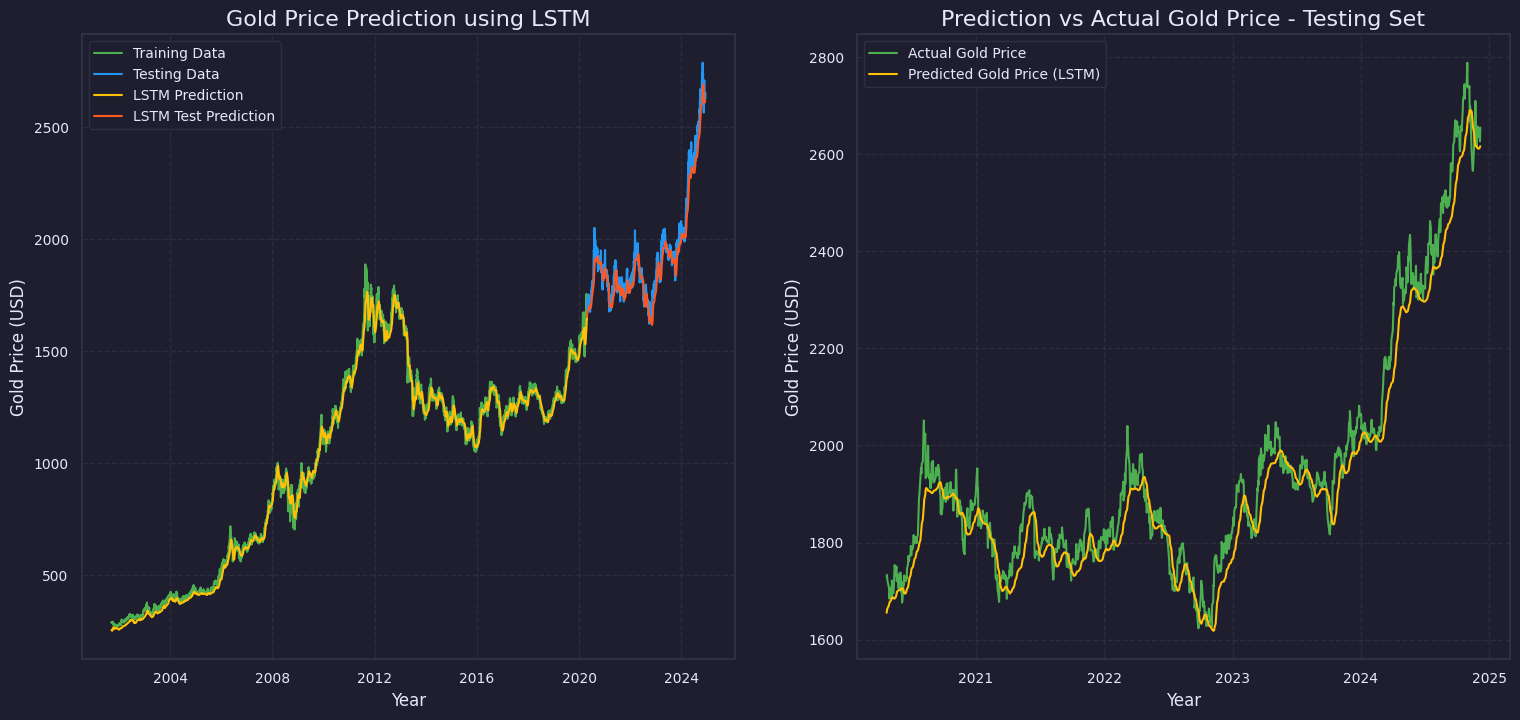

In [104]:
# Visualize Results for LSTM, GRU, and RNN
train_index = data.index[seq_length:train_size + seq_length]
test_index = data.index[train_size + seq_length:]

# Custom dark background color
background_color = '#1e1e2e'
grid_color = '#31334a'
text_color = '#e8e8fa'

# Set seaborn theme with manual adjustments
sns.set_theme(style="darkgrid")
plt.rcParams.update({
    'axes.facecolor': background_color,  # Dark background for the plot
    'axes.edgecolor': grid_color,
    'grid.color': grid_color,  # Subtle grid color
    'text.color': text_color,  # Light text for readability
    'xtick.color': text_color,
    'ytick.color': text_color,
    'legend.facecolor': background_color,  # Legend with matching background
    'legend.edgecolor': grid_color,
    'axes.labelcolor': text_color,
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 100
})

# Visualize Results for LSTM and Prediction vs Actual
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Horizontal layout

# Subplot 1: Results for LSTM
axes[0].plot(train_index, y_train_inv, label='Training Data', color='#4CAF50', linewidth=1.5)
axes[0].plot(test_index, y_test_inv, label='Testing Data', color='#2196F3', linewidth=1.5)
axes[0].plot(train_index, y_train_pred_inv_lstm, label='LSTM Prediction', color='#FFC107', linewidth=1.5)
axes[0].plot(test_index, y_test_pred_inv_lstm, label='LSTM Test Prediction', color='#FF5722', linewidth=1.5)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Gold Price (USD)")
axes[0].set_title("Gold Price Prediction using LSTM")
axes[0].legend(loc="upper left")
axes[0].grid(color=grid_color, linestyle='--', alpha=0.7)

# Subplot 2: Prediction vs Actual (LSTM)
axes[1].plot(test_index, y_test_inv, label='Actual Gold Price', color='#4CAF50', linewidth=1.5)
axes[1].plot(test_index, y_test_pred_inv_lstm, label='Predicted Gold Price (LSTM)', color='#FFC107', linewidth=1.5)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Gold Price (USD)")
axes[1].set_title("Prediction vs Actual Gold Price - Testing Set")
axes[1].legend(loc="upper left")
axes[1].grid(color=grid_color, linestyle='--', alpha=0.7)

# Global figure adjustments
fig.patch.set_facecolor(background_color)  # Overall figure background
fig.tight_layout(pad=3.0)

# Show the combined plots
plt.show()

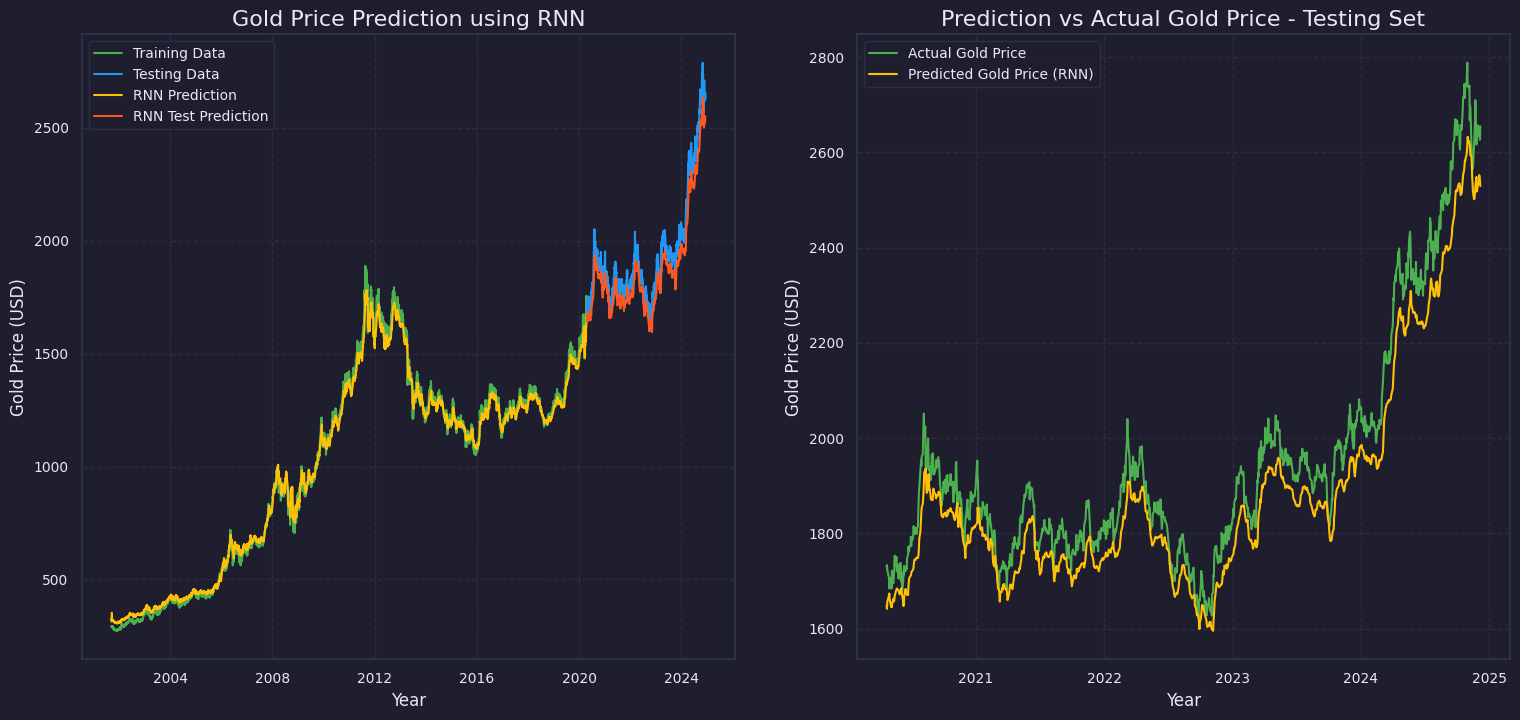

In [105]:
# Visualize Results for RNN and Prediction vs Actual
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Horizontal layout

# Subplot 1: Results for RNN
axes[0].plot(train_index, y_train_inv, label='Training Data', color='#4CAF50', linewidth=1.5)
axes[0].plot(test_index, y_test_inv, label='Testing Data', color='#2196F3', linewidth=1.5)
axes[0].plot(train_index, y_train_pred_inv_rnn, label='RNN Prediction', color='#FFC107', linewidth=1.5)
axes[0].plot(test_index, y_test_pred_inv_rnn, label='RNN Test Prediction', color='#FF5722', linewidth=1.5)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Gold Price (USD)")
axes[0].set_title("Gold Price Prediction using RNN")
axes[0].legend(loc="upper left")
axes[0].grid(color=grid_color, linestyle='--', alpha=0.7)

# Subplot 2: Prediction vs Actual (RNN)
axes[1].plot(test_index, y_test_inv, label='Actual Gold Price', color='#4CAF50', linewidth=1.5)
axes[1].plot(test_index, y_test_pred_inv_rnn, label='Predicted Gold Price (RNN)', color='#FFC107', linewidth=1.5)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Gold Price (USD)")
axes[1].set_title("Prediction vs Actual Gold Price - Testing Set")
axes[1].legend(loc="upper left")
axes[1].grid(color=grid_color, linestyle='--', alpha=0.7)

# Global figure adjustments
fig.patch.set_facecolor(background_color)  # Overall figure background
fig.tight_layout(pad=3.0)

# Show the combined plots
plt.show()


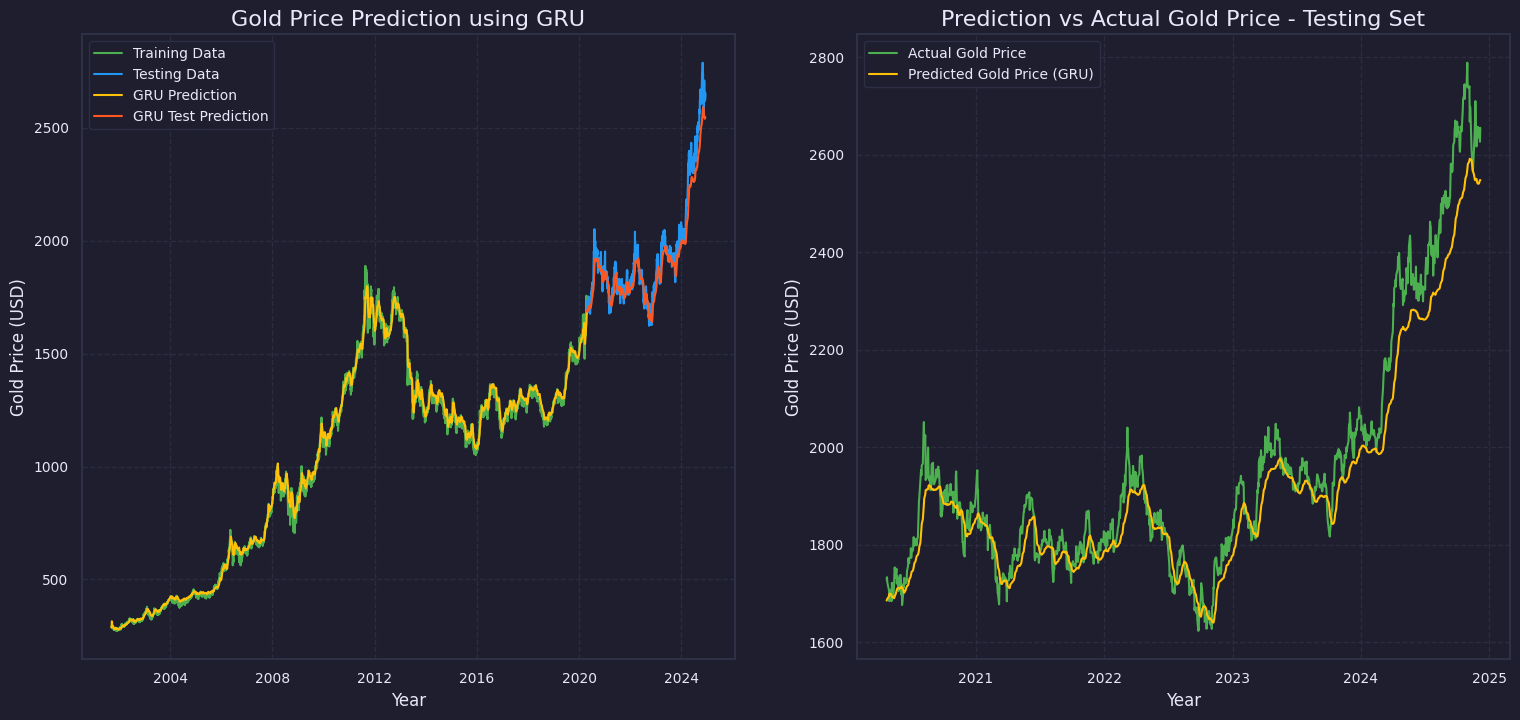

In [106]:
# Visualize Results for GRU and Prediction vs Actual
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Horizontal layout

# Subplot 1: Results for GRU
axes[0].plot(train_index, y_train_inv, label='Training Data', color='#4CAF50', linewidth=1.5)
axes[0].plot(test_index, y_test_inv, label='Testing Data', color='#2196F3', linewidth=1.5)
axes[0].plot(train_index, y_train_pred_inv_gru, label='GRU Prediction', color='#FFC107', linewidth=1.5)
axes[0].plot(test_index, y_test_pred_inv_gru, label='GRU Test Prediction', color='#FF5722', linewidth=1.5)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Gold Price (USD)")
axes[0].set_title("Gold Price Prediction using GRU")
axes[0].legend(loc="upper left")
axes[0].grid(color=grid_color, linestyle='--', alpha=0.7)

# Subplot 2: Prediction vs Actual (GRU)
axes[1].plot(test_index, y_test_inv, label='Actual Gold Price', color='#4CAF50', linewidth=1.5)
axes[1].plot(test_index, y_test_pred_inv_gru, label='Predicted Gold Price (GRU)', color='#FFC107', linewidth=1.5)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Gold Price (USD)")
axes[1].set_title("Prediction vs Actual Gold Price - Testing Set")
axes[1].legend(loc="upper left")
axes[1].grid(color=grid_color, linestyle='--', alpha=0.7)

# Global figure adjustments
fig.patch.set_facecolor(background_color)  # Overall figure background
fig.tight_layout(pad=3.0)

# Show the combined plots
plt.show()
